==============================================================================================
# Practicum 5 - Part 2

==============================================================================================

## Delivery

Up to **1 point out of 10** will be penalized if the following requirements are not fulfilled:

- Implemented code should be commented.

- The questions introduced in the exercises must be answered.

- Add title to the figures to explain what is displayed.

- Comments need to be in **english**.

- The deliverable must be a file named **P5_Student1_Student2.zip** that includes:
    - The notebook P5_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.

**Deadline (Group A- Group F): November 30th, 23:00 h**

**Deadline (Group B): November 1st, 23:00 h**

==============================================================================================
##  Image search using textures
==============================================================================================

#### Problem we want to solve
- Given a query image **$x$** and a set of images **$X$** we would like to retreive the most similar to **$x$** images from  **$X$**.

The exercises of this notebook will show how we can perform image similarity search using:

**Part 1:**

- Gaussian filters
- Descriptors based on texture 

**Part 2:**

- Distance between images and similarity search

### Imports

In [6]:
%matplotlib inline

import time
import scipy
import numpy as np
import skimage
from skimage import filters
from skimage import io
from skimage.color import rgb2gray, rgba2rgb
from skimage.transform import resize

from scipy.ndimage import convolve


import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import joblib  ## 


# Wrapper function to easily use subplot    
import math
def print_images(images, titles=None, ncols=None, colormap=None):
    if ncols == None: #If no number of columns is given, we will print everything in one row
        ncols = len(images)
    if titles == None or len(titles) != len(images): #Empty titles if no titles given or dimension mismatch 
        titles = ["" for i in range(len(images))]
    
    nrows = math.ceil(len(images)/ncols) #Compute the number of rows required to print everythong in ncols
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, squeeze=False, figsize=(15,5)) #Generate subplot
    
    #Switch off every axis
    for x in ax.ravel():
        x.axis("off")
        
    for i in range(nrows):
        for j in range(ncols):
            if i*ncols + j >= len(images): #Stop if every image has been printed, even if the grid is not "complete"
                break;
            ax[i,j].imshow(images[i*ncols + j], cmap=colormap) #Set subplot with given colormap
            ax[i,j].set_title(titles[i*ncols + j])
    plt.show() #Show subplots
    return

# RGB convolution
def convolute_rgb(im, mask):
    im_conv = img_as_ubyte(rgba2rgb(im)) #Convert the image to rgb and to uint (we could also convolute as float)
    for i in range(3): #For each channel
        im_conv[..., i] = convolve(im_conv[...,i], mask) #Do a 2D convolution with selected mask
    return im_conv

#Function to easily print image details
def print_im_detail(image):
    print('Type: ', image.dtype, ' Min.value: ', image.min(), ' Max.value: ', image.max(), ' Image shape: ', image.shape)
    
#Normalization function
def normalize(image):
    return (image.copy()-image.min())/(image.max()-image.min())

# 1 Import previous functions



## Leung-Malik (LM) Filter Bank
We can apply a collection of multiple filters that we call a filter bank. Note that if we apply $D$ filters our feature vectors will be $D$ dimensional.

The following image shows a filter bank. In the filter bank we typically want filters to capture a combination of scales, orientations of different types of patterns. This particular filter bank is The Leung-Malik (LM) Filter Bank.

<img src="./images_notebook/filter_bank.png">

We import Leung-Malik filters as follows:

In [7]:
import LM_filters

In [8]:
filter_bank = LM_filters.makeLMfilters()
filter_bank.shape

(49, 49, 48)

### Plotting all filters

In [9]:
n_filters = filter_bank.shape[-1]

fig, ax = plt.subplots(ncols=12, nrows=4, figsize=(15,3))

k = 0
for i in range(4):
    for j in range(12):
        ax[i,j].imshow(filter_bank[:,:,k], cmap = 'gray')
        ax[i,j].axis("off")
        k = k + 1

## Import functions

We need to use `extract_features()` and  `get_dataset_features()` from **Practicum 5 - Part 1**.

On the one hand, function `extract_features(image, filter_bank, n_filters)` returns a feature vector of shape `n_filters`, from the filter bank, using a  single image `image`

$$
\text{feat}(x) = \left( \text{mean}( |r_1|), \dots,\text{mean}(|r_D|) \right)
$$


In [10]:
def extract_features(image, filter_bank, n_filters=None):
    if n_filters == None:
        n_filters = filter_bank.shape[-1] #If no number of filters is given, use all of them
    
    masked = np.asarray([np.abs(convolve(image, fil)) for fil in filter_bank[..., :n_filters]]) #Compute the absoute value of the convolutions
    features = np.asarray([np.mean(img) for img in masked]) #Then compute the mean for each convolution
    return features

On the other hand, function `get_dataset_features(all_images, filter_bank)`, that applies `extract_features()`, returns a matrix containing the feature vectors for all the images in a dataset.

In [11]:
def get_dataset_features(all_images,  filter_bank, n_filters=None):
    if n_filters == None:
        n_filters = filter_bank.shape[-1] #Get the number of filters
    feature_vectors = np.asarray([extract_features(image, filter_bank, n_filters) for image in all_images]) #Extract feature with all filters for each image
    
    return feature_vectors

**Hint: Please, check all the functions are well working before continuing!!!**

## Load & resize the dataset

**3.1** Similarly to **Practicum 5 - Part 1**, read all the images in the directories, **resized them to 250x250 pixels** and save the image in an array:

<ul>
    <li>./images/pizza/</li>
    <li>./images/flowers/</li>
    <li>./images/pets/</li>
</ul>


In [12]:
# Your solution here
#We use the ImageCollection to load all the images in the given directiories
pizza_images = io.ImageCollection("./images/pizza/*")
flowers_images = io.ImageCollection("./images/flowers/*")
pets_images = io.ImageCollection("./images/pets/*")

#ImageCollection returns a ImageCollection object, we pass them to array, resizing them to 250x250
pizza_images = [resize(elem, (250,250, 3)) for elem in pizza_images]
flowers_images = [resize(elem, (250,250, 3))  for elem in flowers_images]
pets_images = [resize(elem, (250,250, 3))  for elem in pets_images]

print(len(pizza_images), len(flowers_images), len(pets_images))


30 28 29


In [18]:
## Try the function
all_images = pizza_images + flowers_images + pets_images
all_images_gray = [rgb2gray(image) for image in all_images] #Same as all_images but with grayscale images

'''
We could compute the feature vectors directly, but as it takes some time, we serialized them and saved into 
feature_vectors.pkl file. The following code tries to load the object into feature_vectors if the file is available.
If it is not, then we compute the feature vectors and save them into said file.

We have included the serialized file into the zip folder, if you want the code to actually compute them, just delete
the file or change the name in the filename variable. 

CAUTION: We have detected that moving the serialized files between computers produces some strange behaviour, we 
advise to recompute, though it may change some of the results
'''

import pickle
filename = 'feature_vectors.pkl'
try:
    #If the file exists, load its contents to feature_vectors
    with open(filename, 'rb') as fp:
        feature_vectors = pickle.load(fp)
except:
    #Otherwise, compute feature_vectors
    feature_vectors = get_dataset_features(all_images_gray, filter_bank)
    
    #and then serialize them
    with open(filename, 'wb') as fp:
        pickle.dump(feature_vectors, fp, pickle.HIGHEST_PROTOCOL)


# 2 Retrieving the most similar images


## Similarity search

Let us assume $f(x) \in \mathbb{R}^D$ represents a set of features for $x$. Given a query image $x$ and another image $x^m$ from the database, we can compute the distance between images as
$$
\text{distance}\left( f(x) , \, f(x^m) \right) = \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 =  \sqrt{ \sum_{d=1}^\text{D} \left( f(x)_d - f(x^m)_d  \right)^2 }
$$

then we can find the closest image $x^{m^*}$ from the database to $x$ as $m^* =  \text{argmin}_{m} \{ \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 \}$




**3.2** Implement a function `retrieve_images(im, all_images, filter_bank, k=5)` to retrieve and visualize the `k` most similar images (according to the l2 norm) to `im` and the corresponding distances.

The input of this function need to be the images of interest `im`, the whole data set `all_images`, the filter bank and an integer value `k`, which defines the number of images to be shown.

The function should return the ordered vector of distances.

<img src="./images/indice.png" >


In [19]:
'''
It's implied that the closest and distances vectors should be ordered. If this was not the case, we could
have used the np.argpartition(distances, k)[:k] instead of np.argsort(distances)[:k]. The first function
assures that the k smallest indices are in the first k positions (but not necessarily ordered) and it 
runs in O(n). The later actually sorts the whole array, so it's more expensive as we only need the k smallest ones.
'''

#The asked function
def retrieve_images(im, all_images, filter_bank, k=5): 
    img_features = extract_features(im, filter_bank) #Get image features
    distances = np.asarray([np.linalg.norm(im_features - extract_features(col_im, filter_bank)) for col_im in all_images]) #Compute distance between the image feature vector and the vector feature vector of every other image
    closest = np.argsort(distances)[:k] #Get the sorted indices and keep only the k most similar ones
    k_dinstances = distances[closest] #Get the distances 
    
    return closest, k_distances #Return the indices and distances of the k most similar ones.

#Variation of the function above but with the feature vectors precomputed. The one we will actually use.
# it allows to compute the feature vectors once and perform the retrival many times without recomputing them
def retrive_images_computed(im_features, all_image_features, k=5):
    distances = np.asarray([np.linalg.norm(im_features - col_im) for col_im in all_image_features])
    closest = np.argsort(distances)[:k]
    k_distances = distances[closest]
    
    return closest, k_distances

Try your function using ``/images/pizza.jpg``.

In [20]:
pizza = rgb2gray(resize(io.imread('./images/pizza.jpg'), (250, 250, 3))) #Load pizza, resize it
pizza_features = extract_features(pizza, filter_bank) # and extract its features

In [22]:
# Try your function
#closest, distances = retrieve_images( pizza, all_images, filter_bank, k=5)
closest, distances = retrive_images_computed(pizza_features, feature_vectors) #Notice we use the precomputed verision

Plot the ordered distance vector

In [23]:
# Your solution here
#Plot the images with their respective distances
print_images([all_images[i] for i in closest], ["Distance: %f" % i for i in distances], colormap='gray')

**3.3** Try your function using a different number of closest images `k`.

In [24]:
# Your solution here
#closest, distances = retrieve_images( pizza, all_images, filter_bank, k=5) #We use the precomputed version
closest, distances = retrive_images_computed(pizza_features, feature_vectors, k=10)
print(closest)
print_images([all_images[i] for i in closest], ["Distance: %f" % i for i in distances], ncols=5, colormap='gray')

[ 5 19 16 15 41 53 23 42 66 84]


**3.4** (Optional) Try your function using ``/images/dog.jpg``, and ``/images/flower.jpg``

In [25]:
# Your solution here
dog = rgb2gray(resize(io.imread('./images/dog.jpg'), (250, 250, 3)))
dog_features = extract_features(dog, filter_bank)

closest, distances = retrive_images_computed(dog_features, feature_vectors)
print_images([all_images[i] for i in closest], ["Distance: %f" % i for i in distances], colormap='gray')

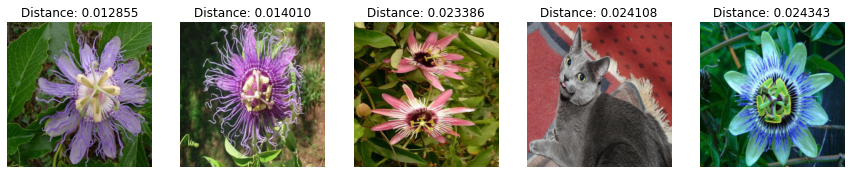

In [15]:
flower = rgb2gray(resize(io.imread('./images/flower.jpg'), (250, 250, 3)))
flower_features = extract_features(flower, filter_bank)

closest, distances = retrive_images_computed(flower_features, feature_vectors)
print_images([all_images[i] for i in closest], ["Distance: %f" % i for i in distances], colormap='gray')

## Compute the accuracy of the algorithm: given a query image. 

**3.5** Implement a function `accuracy(feature_vectors, class_labels, im_features, class_im,  k=5)`, which takes as input `feature_vectors`, the `class_labels` for the images (`0 = pizza`, `1 = flower` and `2 = pet`), the number of images to retrieve `k`, a query image (i.e. the feature vector for the image of interest) and the class of the query image `class_im`. 

Returns as output the number of retrieved images that belong to class `class_im` divided by the total of images retrieved `k` (this is the accuracy).

**Hint**: Be careful to exclude the query image from the retrieved images (i.e. those cases in which `distance=0.0`)

In [26]:
#We have changed the values since there are not 30 pictures in each category
class_labels = np.concatenate((np.zeros(30), np.ones(28),  2*np.ones(29))).reshape(87,1)

In [34]:
def accuracy(feature_vectors, class_labels, im_features, class_im, k=5):
    tol = 1e-3
    distances = np.asarray([np.linalg.norm(im_features - col_img) for col_img in feature_vectors]) #Compute each distance
    closest = np.argsort(distances)[:k+1] #Sort them (again, using np.argpartition is faster). We take k+1 in case the query is retrived
    if distances[closest[0]] <= tol: #If the closest has distance 0 it is the same as the query
        closest = closest[1:k+1] #So we discard them and get the next one
    else:
        closest = closest[:k] #Else, just get the first k images
    print("Closest indices: ",closest)
    print("Distances: ", distances[closest])
    counts = np.count_nonzero(class_labels[closest] == class_im) #Count how many of the labels of the closest images are the same as the query
    acc = counts/k 
    return acc


In [35]:
# Try your function
pizza = io.imread('./images/pizza.jpg')
pizza = rgb2gray(resize(pizza, (250,250,3)))
#feature_vectors = get_dataset_features(all_images, filter_bank, n_filters=5) #We already have them in feature_vectors
im_features = extract_features(pizza, filter_bank)
print("acc: ", accuracy(feature_vectors, class_labels, im_features, 0, k=5))

Closest indices:  [19 16 15 41 53]
Distances:  [0.02669858 0.02739881 0.04694686 0.05246408 0.0526941 ]
acc:  0.6


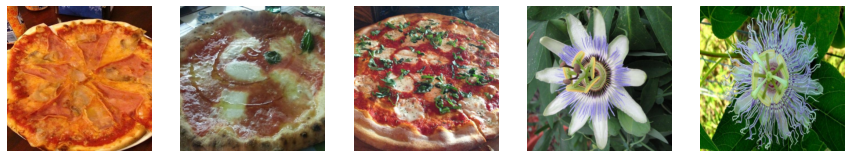

In [30]:
print_images([all_images[x] for x in [19,16,15,41,53]])
#We can see 3 out of 5 are from the same class, and 3/5=0.6

Compute the accuracy with k=10 with the previous images. Does the accuracy match the images retrieved from the previous exercise?

In [31]:
# Your solution here
print("acc: ", accuracy(feature_vectors, class_labels, im_features, 0, k=10))

Closest indices:  [19 16 15 41 53 23 42 66 84  0]
Distances:  [0.02669858 0.02739881 0.04694686 0.05246408 0.0526941  0.06697728
 0.07059062 0.10124151 0.1332666  0.1552011 ]
acc:  0.5


In [27]:
'''
We can see that they are the same as in the previous exercise (which gave us the indices [ 5 19 16 15 41 53 23 42 66 84])
except for the first one, because in the previous exercise we considered also the queried image (which is in index 5). 
As it is not considered in this exercise, it does not appear and there is an extra one at the end (the index 0)
'''

'\nWe can see that they are the same as in the previous exercise (which gave us the indices [ 5 19 16 15 41 53 23 42 66 84])\nexcept for the first one, because in the previous exercise we considered also the queried image (which is in index 5). \nAs it is not considered in this exercise, it does not appear and there is an extra one at the end (the index 0)\n'

**3.6** Modify (if necessary) functions `extract_features()` and `get_dataset_features()` in order to use only a given number of filters. Compute the accuracy using `n_filters=6`, `n_filters=18` and `n_filters=36`. 

Comment the results.

In [33]:
#CAUTION!!! It takes some time to rerun this cell since we are getting the features of all images for n=6,18,36
do_you_want_to_rerun = True
assert do_you_want_to_rerun

pizza = io.imread('./images/pizza.jpg')
pizza = rgb2gray(resize(pizza, (250,250,3)))

for i in [6,18,36]:
    im_features_reduced = extract_features(pizza, filter_bank, n_filters=i)
    feature_vectors_reduced = get_dataset_features(all_images_gray, filter_bank, n_filters=i)
    print("Accuracy for n_filters = %i: " % i, accuracy(feature_vectors_reduced, class_labels, im_features_reduced, 0, k=10))

Closest indices:  [ 0 19 16 15 22 42 84 41 37 24]
Distances:  [0.0009742  0.00261856 0.00271032 0.00338886 0.0035754  0.00359801
 0.00368953 0.00428209 0.00479072 0.00548855]
Accuracy for n_filters = 6:  0.6
Closest indices:  [ 0 19 16 22 15 42 41 14 37 84]
Distances:  [0.00216348 0.0030197  0.00494981 0.00503437 0.00509625 0.00528424
 0.00560764 0.00618363 0.00633285 0.00655765]
Accuracy for n_filters = 18:  0.6
Closest indices:  [ 0 42 37 19 16 66 41 15 22 84]
Distances:  [0.00358073 0.00382484 0.00432776 0.00496215 0.00649579 0.00650456
 0.00672061 0.00734378 0.00765764 0.00777117]
Accuracy for n_filters = 36:  0.5


## Answer
The results are the following (for $k=10$ images):

| n_filters | accuracy |
|:---: | :---:|
| 6| 0.6 (6/10) |
| 18 | 0.6 (6/10)|
| 36 | 0.5 (5/10)|

THis means that the most important filters for this image are the 18 first filters (corresponding to the "edges"), and when we start adding the "bars" the number of similar images increases.

**3.7** (Optional) Try your function using other images and modifying the number of filters to be used.

**Hint:** You can use `im_features = feature_vectors[j]` and `class_im = class_labels[j]`, for a given `j` value, in order to simplify the problem, instead of recomputing the features for a new image. **Remember** to exclude the query image from the retrieved images!.

In [ ]:
# Your solution here

# 3 Image retrieval based on texture and color. 

**3.8** Make a function ` lm_features_rgb`  that returns the features based on a color descriptor. 

**Hint:** How will you define it? What should be the dimensonality of the new descriptor?.


## Answer
For a feature vector based on color, we can use the concatenation of each channel. The dimensionality of the descriptor will depend on the number of bins used in the histograms. As instance, if we use $16$ bins histograms, we will get a descriptor of size $16\times 3 = 48$ 

In [59]:
from skimage.exposure import histogram
from skimage import img_as_float


def lm_features_rgb(image, n_bins=16):
    hst_r, bins_r = histogram(image[:,:,0], nbins=n_bins)
    hst_g, bins_g = histogram(image[:,:,1], nbins=n_bins)
    hst_b, bins_b = histogram(image[:,:,2], nbins=n_bins)
    
    #return np.concatenate((hst_r/np.linalg.norm(hst_r), hst_g/np.linalg.norm(hst_g), hst_b/np.linalg.norm(hst_b))) #If we normalize each component it works a bit better
    return np.concatenate((hst_r, hst_g, hst_b))

In [37]:
pizza = io.imread('./images/pizza.jpg')
#pizza = io.imread('./images/pizza/3678290.jpg')
pizza = resize(pizza, (250,250,3)) #This time we keep the image in RGB
lm_rgb_features = lm_features_rgb(pizza)
print(lm_rgb_features.shape)

(48,)



## Apply the function to all the images in the dataset

**3.9** Using ` lm_features_rgb` build the features of all the datapoints in and save them in `X_lm_rgb`.

**Hint:** You can parallelize the feature building process using `joblib.Parallel`. This will make the computation much faster if you have a processor with more than two threads.

In [38]:
# Your solution here

In [60]:
import joblib
X_lm_rgb = joblib.Parallel(n_jobs=8)(joblib.delayed(lm_features_rgb)(im, n_bins=16) for im in all_images)

In [41]:
print(len(X_lm_rgb))

87


## Compute the accuracy of the method using lm rgb features

**3.10** Compute the accuracy of the retrieved images using the features that contain color information. Make a plot of the 4 closest images to the query images in the `lm_rgb` space.

Is the accuracy higher? Please, comment the results.

In [49]:
# Your solution here
def accuracy_colors(color_feature_vectors, class_labels, im_colors, class_im, k=5):
    distances = np.asarray([np.linalg.norm(im_colors - col_img) for col_img in color_feature_vectors])
    closest = np.argsort(distances)[:k+1]
    if distances[closest[0]] == 0.0:
        closest = closest[1:k+1]
    else:
        closest = closest[:k]
    print(closest)
    counts = np.count_nonzero(class_labels[closest] == class_im)
    acc = counts/k
    return closest, distances, acc

closest, distances, acc = accuracy_colors(X_lm_rgb, class_labels, lm_rgb_features, 0, 4)
print(acc)
print(distances[closest])

[77 20 74 24]
0.5
[16364.02676605 16984.16291726 17823.47564309 18770.96966062]


In [162]:
print_images([all_images[x] for x in [77, 20, 74, 24]])

## Answer
THe accuracy happens to be the worse than before with $k=4$ (0.5 using only colors vs 0.75 using only textures) same as above with $k=5$ but with $k=10$ it improves (0.8 now vs 0.6 before), since the flowers we were finding before are a lot different in color. Observing the images, we can see that the most simailar image is actually a dog, as well as the third one (as they have similar colors and thus similar histograms). Also note that we are using the image pizza.jpg which is fairly different to the other pizza images in terms of color, a lot of pixels are blue due to the background plate. If we use, for example the image 3678290.jpg (a more typical color distribution for a pizza) results are much better.

## Compare the accuracy of the method using a) texture, b) color and c) texture + color  features

**3.10** Compute the accuracy of the retrieved images using the features that contain color information. Make a plot of the 4 closest images to the query images in the `lm_rgb` space.

Is the accuracy higher? Please, comment the results.

In [163]:
# Your solution here
#Done above


**3.11** Compute the accuracy of the retrieved images using the features that contain texture and color information. Make a plot of the 4 closest images to the query images in the `lm_rgb_texture` space.

Is the accuracy higher? Please, comment the results.

In [64]:
# Your solution here
pizza = resize(io.imread('./images/pizza.jpg'), (250, 250, 3)) #Load pizza, resize it
#pizza = resize(io.imread('./images/pizza/3678290.jpg'), (250,250,3))
pizza_texture = extract_features(rgb2gray(pizza), filter_bank) # and extract its features
pizza_rgb = lm_features_rgb(pizza)

'''
We get the combined features by concatenating the histograms and the filter responses. We normalize each vector, 
because the values of the histograms are much bigger than the filter bank. If we use only the concatenated vectors
the output will be the same as using only the rgb descriptor. 

The accuracy is somehow worse than before, probably because we are getting more 
results with high blue values in histogram (again, if we use a more typical pizza
like 3678290.jpg it works a lot better).
'''
#combined_features = [np.concatenate((rgb, texture)) for rgb, texture in zip(X_lm_rgb, feature_vectors)]
#pizza_features = np.concatenate((pizza_rgb, pizza_texture))

combined_features = [np.concatenate((rgb/np.linalg.norm(rgb), texture/np.linalg.norm(texture))) for rgb, texture in zip(X_lm_rgb, feature_vectors)]

pizza_features = np.concatenate((pizza_rgb/np.linalg.norm(pizza_rgb), pizza_texture/np.linalg.norm(pizza_texture)))


print("acc: ", accuracy(combined_features, class_labels, pizza_features, 0, k=4))


Closest indices:  [77 20 74 31]
Distances:  [0.5192529  0.53971104 0.56222056 0.59493639]
acc:  0.25


In [51]:
print_images([all_images[x] for x in [77, 20, 74, 31]])